<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_SARIMA_otsoniennustamiseen_(v3_Korjattu_syntaksi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- SARIMA Ozone Forecasting Script (Univariate - v3 - Syntax Corrected) ---

Ladataan otsonidataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv
Lukeminen CSV:stä (käyttäen Kallio-spesifiä logiikkaa: iso-8859-1, sep=,, dec=,, skip=1)...
Palautetaan DataFrame, muoto: (43180, 1)

Tarkistetaan ladattu DataFrame...
DataFrame OK, jatketaan mallinnukseen.

Ladattu 43180 riviä otsonidataa.

--- 2. Stationarisuus ja kausivaihtelu ---
Käytetään ei-kausittaista differointia d=0.
Oletetaan kauden pituudeksi s=24.
Käytetään kausittaista differointia D=1.

--- 3. SARIMA-järjestyksen määrittäminen (käytetään d=0, D=1, s=24) ---
Käytetään YKSINKERTAISTETTUA SARIMA-järjestystä: (p=1, d=0, q=1) (P=0, D=1, Q=0, s=24)
Piirretään ACF/PACF sarjalle (d=0, D=1)...


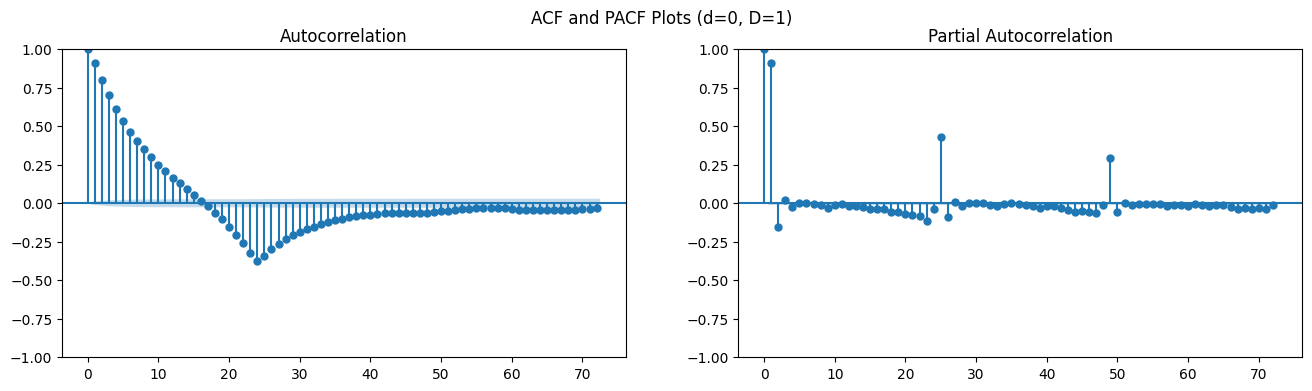


--- 4. Datan jako opetus- ja testijoukkoihin ---
Opetusdata: 0 - 39510 (38862 riviä)
Testidata: 39511 - 43842 (4318 riviä)

--- 5. SARIMA-mallin sovittaminen opetusdataan (yksinkertaistettu järjestys) ---
Aloitetaan SARIMA-mallin sovitus...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA-malli sovitettu.

--- 6. Ennusteiden tekeminen testijaksolle ---
Ennustetaan numeerisilla indekseillä: start=38862, end=43179
Ennusteiden indeksi muutettu aikaleimoiksi.

--- 7. Mallin evaluointi ---
Test RMSE: 20.993
Test MAE: 17.440


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


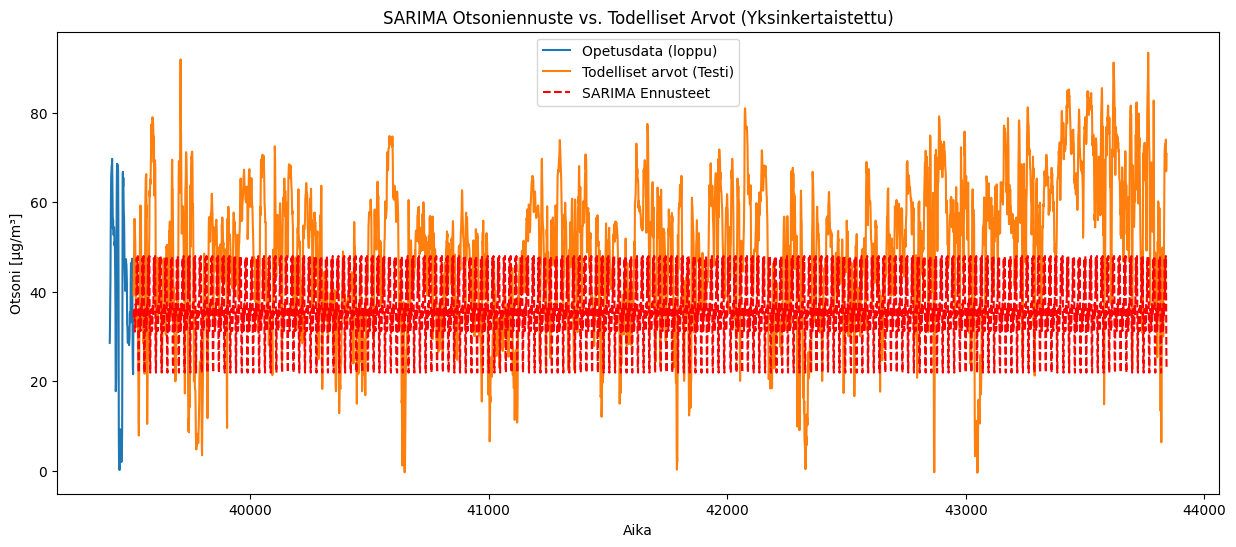


--- 8. Piikkien päätteleminen ennusteista (valinnainen) ---
Käytetään piikin kynnysarvoa (opetusdatan 90. persentiili): 77.90

SARIMA Piikkiennusteiden (päätelty) evaluointi:
Ei voitu laskea luokitteluraporttia (testidatassa tai ennusteissa vain yhtä luokkaa).
Todellisia piikkejä testidatassa: 105
Ennustettuja piikkejä: 0

--- SARIMA-skripti päättyi ---


In [1]:
# -*- coding: utf-8 -*-
"""
Colab Script for SARIMA Ozone Forecasting (Helsinki Kallio) - v3

Loads Kallio ozone data, checks stationarity, fits a SIMPLIFIED SARIMA model,
makes predictions, and evaluates. Corrected syntax error in prediction slicing.
NOTE: This is a univariate model and does NOT use weather data.
"""

# Kirjastojen tuonti
import pandas as pd
import numpy as np
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

# Aikasarja-analyysikirjastot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from math import sqrt
# import pmdarima as pm

print("--- SARIMA Ozone Forecasting Script (Univariate - v3 - Syntax Corrected) ---")

# --- Funktio datan lataamiseen ja peruspuhdistukseen (Otsoni) ---
def load_and_clean_ozone_data(raw_url):
    """Lataa ja esikäsittelee otsonidatan annetusta URL:sta."""
    print(f"\nLadataan otsonidataa: {raw_url}")
    df_local = None
    try:
        response = requests.get(raw_url)
        response.raise_for_status()
        print("Lukeminen CSV:stä (käyttäen Kallio-spesifiä logiikkaa: iso-8859-1, sep=,, dec=,, skip=1)...")
        csv_content = io.StringIO(response.content.decode('iso-8859-1'))
        column_names_ozone = ["Havaintoasema", "Vuosi", "Kuukausi", "Päivä", "Aika [Paikallinen aika]", "Otsoni [µg/m³]"]
        df_local = pd.read_csv(
             csv_content, sep=',', decimal=',', skiprows=1, header=None,
             names=column_names_ozone, quoting=csv.QUOTE_NONNUMERIC, low_memory=False
        )

        o3_col = "Otsoni [µg/m³]"
        if o3_col in df_local.columns:
             df_local[o3_col] = pd.to_numeric(df_local[o3_col], errors='coerce')
        else:
             print(f"Virhe: Otsonisarake '{o3_col}' ei löytynyt.")
             return None

        year_col, month_col, day_col, time_col = 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]'
        required_dt_cols = [year_col, month_col, day_col, time_col]
        if not all(col in df_local.columns for col in required_dt_cols):
             print(f"Virhe: Aikaleiman luontiin vaadittavia sarakkeita puuttuu: {required_dt_cols}")
             return None

        df_local[year_col] = pd.to_numeric(df_local[year_col], errors='coerce').astype('Int64')
        df_local[month_col] = pd.to_numeric(df_local[month_col], errors='coerce').astype('Int64')
        df_local[day_col] = pd.to_numeric(df_local[day_col], errors='coerce').astype('Int64')
        if df_local[required_dt_cols].isnull().any().any():
             df_local.dropna(subset=required_dt_cols, inplace=True)

        df_local[year_col] = df_local[year_col].astype(str)
        df_local[month_col] = df_local[month_col].astype(str).str.zfill(2)
        df_local[day_col] = df_local[day_col].astype(str).str.zfill(2)
        df_local[time_col] = df_local[time_col].astype(str)
        time_str = df_local[time_col].str.replace('24:00', '00:00', regex=False)
        datetime_str = df_local[year_col] + '-' + df_local[month_col] + '-' + df_local[day_col] + ' ' + time_str
        df_local['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce')
        df_local.loc[df_local[time_col] == '24:00', 'Timestamp'] += pd.Timedelta(days=1)

        initial_rows_before_dropna = len(df_local)
        df_local.dropna(subset=['Timestamp', o3_col], inplace=True)

        df_local = df_local[[o3_col]].copy()
        df_local.index = df_local.index
        df_local.sort_index(inplace=True)

        duplicates = df_local.index.duplicated(keep='first')
        num_duplicates = duplicates.sum()
        if num_duplicates > 0:
            print(f"Poistetaan {num_duplicates} duplikaatti-indeksiä.")
            df_local = df_local[~duplicates]

        print(f"Palautetaan DataFrame, muoto: {df_local.shape}")
        if df_local.empty:
            print("VAROITUS: Palautettava DataFrame on tyhjä!")

        return df_local

    except requests.exceptions.RequestException as e:
        print(f"Virhe datan haussa URL:sta: {e}")
        return None
    except Exception as e:
        print(f"Virhe datan käsittelyssä: {e}")
        traceback.print_exc()
        return None

# --- 1. Datan lataus ---
ozone_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv"
df_ozone = load_and_clean_ozone_data(ozone_url)

print("\nTarkistetaan ladattu DataFrame...")
if df_ozone is not None and not df_ozone.empty:
    print("DataFrame OK, jatketaan mallinnukseen.")
    o3_col = "Otsoni [µg/m³]"
    print(f"\nLadattu {len(df_ozone)} riviä otsonidataa.")

    # --- 2. Stationarisuus ja kausivaihtelu ---
    print("\n--- 2. Stationarisuus ja kausivaihtelu ---")
    d = 0 # Perustuen aiempaan ADF-testiin
    print(f"Käytetään ei-kausittaista differointia d={d}.")
    s = 24 # Oletetaan 24 tunnin kausivaihtelu
    print(f"Oletetaan kauden pituudeksi s={s}.")
    D = 1 # Kokeillaan edelleen kausittaista differointia, mutta P=0, Q=0
    print(f"Käytetään kausittaista differointia D={D}.")

    # --- 3. SARIMA-järjestyksen (p,d,q)(P,D,Q,s) määrittäminen ---
    print(f"\n--- 3. SARIMA-järjestyksen määrittäminen (käytetään d={d}, D={D}, s={s}) ---")
    # *** YKSINKERTAISTETTU JÄRJESTYS ***
    p = 1 # Yksinkertaistettu
    q = 1 # Yksinkertaistettu
    P = 0 # Yksinkertaistettu (ei kausittaista AR)
    Q = 0 # Yksinkertaistettu (ei kausittaista MA)
    print(f"Käytetään YKSINKERTAISTETTUA SARIMA-järjestystä: (p={p}, d={d}, q={q}) (P={P}, D={D}, Q={Q}, s={s})")
    sarima_order = (p, d, q)
    seasonal_order = (P, D, Q, s)

    # Piirretään ACF/PACF (edelleen hyödyllistä nähdä)
    data_for_acf = df_ozone[o3_col].dropna()
    if d > 0: data_for_acf = data_for_acf.diff(periods=d)
    if D > 0: data_for_acf = data_for_acf.diff(periods=s)
    data_for_acf.dropna(inplace=True)

    print(f"Piirretään ACF/PACF sarjalle (d={d}, D={D})...")
    if not data_for_acf.empty:
        try:
            fig, ax = plt.subplots(1, 2, figsize=(16, 4))
            plot_acf(data_for_acf, lags=min(72, len(data_for_acf)//2 - 1), ax=ax[0])
            plot_pacf(data_for_acf, lags=min(72, len(data_for_acf)//2 - 1), ax=ax[1])
            plt.suptitle(f'ACF and PACF Plots (d={d}, D={D})')
            plt.show()
        except Exception as e_acf:
            print(f"Virhe ACF/PACF-kuvaajien piirtämisessä: {e_acf}")
    else:
        print("Ei voitu piirtää ACF/PACF: data tyhjä differoinnin jälkeen.")


    # --- 4. Datan jako opetus- ja testijoukkoihin ---
    print("\n--- 4. Datan jako opetus- ja testijoukkoihin ---")
    test_size = 0.1
    split_index = int(len(df_ozone) * (1 - test_size))
    train_data = df_ozone[o3_col].iloc[:split_index]
    test_data = df_ozone[o3_col].iloc[split_index:]
    print(f"Opetusdata: {train_data.index.min()} - {train_data.index.max()} ({len(train_data)} riviä)")
    print(f"Testidata: {test_data.index.min()} - {test_data.index.max()} ({len(test_data)} riviä)")

    # --- 5. SARIMA-mallin sovittaminen ---
    print("\n--- 5. SARIMA-mallin sovittaminen opetusdataan (yksinkertaistettu järjestys) ---")
    sarima_result = None
    try:
        sarima_model = SARIMAX(train_data,
                               order=sarima_order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)

        print("Aloitetaan SARIMA-mallin sovitus...")
        sarima_result = sarima_model.fit(disp=False)
        print("SARIMA-malli sovitettu.")
        # print(sarima_result.summary()) # Voit poistaa kommentin nähdäksesi yhteenvedon

    except Exception as e_fit:
        print(f"Virhe SARIMA-mallin sovittamisessa: {e_fit}")
        traceback.print_exc()

    # --- 6. Ennusteiden tekeminen ---
    if sarima_result:
        print("\n--- 6. Ennusteiden tekeminen testijaksolle ---")
        try:
            n_train = len(train_data)
            n_total = len(df_ozone)
            start_pred_loc = n_train
            end_pred_loc = n_total - 1

            print(f"Ennustetaan numeerisilla indekseillä: start={start_pred_loc}, end={end_pred_loc}")
            predictions_sarima_numeric = sarima_result.predict(start=start_pred_loc, end=end_pred_loc)

            if len(predictions_sarima_numeric) == len(test_data):
                 predictions_sarima = pd.Series(predictions_sarima_numeric.values, index=test_data.index)
                 print("Ennusteiden indeksi muutettu aikaleimoiksi.")
            else:
                 print(f"Varoitus: Ennusteiden ({len(predictions_sarima_numeric)}) ja testidatan ({len(test_data)}) pituudet eivät täsmää!")
                 # *** KORJATTU SYNTAKSIVIRHE TÄSSÄ ***
                 predictions_sarima = pd.Series(predictions_sarima_numeric.values[:len(test_data)], index=test_data.index)


            # --- 7. Evaluointi ---
            print("\n--- 7. Mallin evaluointi ---")
            try:
                rmse = sqrt(mean_squared_error(test_data, predictions_sarima))
                mae = mean_absolute_error(test_data, predictions_sarima)
                print(f'Test RMSE: {rmse:.3f}')
                print(f'Test MAE: {mae:.3f}')

                plt.figure(figsize=(15, 6))
                plt.plot(train_data.index[-100:], train_data[-100:], label='Opetusdata (loppu)')
                plt.plot(test_data.index, test_data, label='Todelliset arvot (Testi)')
                plt.plot(predictions_sarima.index, predictions_sarima, label='SARIMA Ennusteet', color='red', linestyle='--')
                plt.title('SARIMA Otsoniennuste vs. Todelliset Arvot (Yksinkertaistettu)')
                plt.xlabel('Aika')
                plt.ylabel(o3_col)
                plt.legend()
                plt.show()

                # --- 8. Piikkien päätteleminen (valinnainen) ---
                # (Sama logiikka kuin aiemmin)
                print("\n--- 8. Piikkien päätteleminen ennusteista (valinnainen) ---")
                try:
                    spike_threshold_train = train_data.quantile(0.90)
                    print(f"Käytetään piikin kynnysarvoa (opetusdatan 90. persentiili): {spike_threshold_train:.2f}")
                    predicted_spikes_sarima = (predictions_sarima > spike_threshold_train).astype(int)
                    actual_spikes_test = (test_data > spike_threshold_train).astype(int)

                    print("\nSARIMA Piikkiennusteiden (päätelty) evaluointi:")
                    if len(np.unique(actual_spikes_test)) > 1 and len(np.unique(predicted_spikes_sarima)) > 1:
                         print(classification_report(actual_spikes_test, predicted_spikes_sarima))
                         print("Confusion Matrix:")
                         print(confusion_matrix(actual_spikes_test, predicted_spikes_sarima))
                    else:
                         print("Ei voitu laskea luokitteluraporttia (testidatassa tai ennusteissa vain yhtä luokkaa).")
                         print(f"Todellisia piikkejä testidatassa: {actual_spikes_test.sum()}")
                         print(f"Ennustettuja piikkejä: {predicted_spikes_sarima.sum()}")
                except Exception as e_spike:
                    print(f"Virhe piikkien päättelemisessä: {e_spike}")

            except Exception as e_eval:
                print(f"Virhe evaluoinnissa: {e_eval}")

        except Exception as e_pred:
            print(f"Virhe ennusteiden tekemisessä: {e_pred}")
            traceback.print_exc()

    else: # sarima_result is None
        print("\nEi voitu tehdä ennusteita, koska mallin sovitus epäonnistui.")

else: # df_ozone is None or empty
    print("\nEi voitu jatkaa mallinnukseen, koska datan lataus epäonnistui tai data on tyhjä.")


print("\n--- SARIMA-skripti päättyi ---")